In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import datetime
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import re
import statsmodels.api as sm
plt.style.use('ggplot')

In [2]:
watches = pd.read_csv('luxury watch.csv')

# EDA and Feature Engineering

In [3]:
watches.head()

,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,"9,500"
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,"5,800"
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,"4,200"
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,"7,900"
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,NaN,NaN,"2,800"


In [4]:
watches.dtypes

Brand                   object
Model                   object
Case Material           object
Strap Material          object
Movement Type           object
Water Resistance        object
Case Diameter (mm)     float64
Case Thickness (mm)    float64
Band Width (mm)        float64
Dial Color              object
Crystal Material        object
Complications           object
Power Reserve           object
Price (USD)             object
dtype: object

In [5]:
watches.isna().sum()

Brand                    0
Model                    0
Case Material            0
Strap Material           0
Movement Type            0
Water Resistance         0
Case Diameter (mm)       0
Case Thickness (mm)      0
Band Width (mm)          0
Dial Color               0
Crystal Material         0
Complications          122
Power Reserve           14
Price (USD)              1
dtype: int64

In [6]:
watches.duplicated().sum()

19

In [7]:
# drop duplicated
watches.drop_duplicates(inplace = True)

In [8]:
watches.duplicated().sum()

0

In [9]:
#drop null price, and power reserve
watches.dropna(subset = ['Price (USD)', 'Power Reserve'],axis = 0, inplace = True)

In [10]:
# make Water Resistance and Power Reserve integer columns
print(watches['Water Resistance'].unique(), watches['Power Reserve'].unique())
watches['Water Resistance'] = watches['Water Resistance'].str.split().str.get(0)
watches['Power Reserve'] = watches['Power Reserve'].str.split().str.get(0)

['300 meters' '600 meters' '100 meters' '30 meters' '200 meters'
 '50 meters' '150 meters' '500 meters' '60 meters' '120 meters'
 '1000 meters' '2000 meters'] ['48 hours' '60 hours' '42 hours' '70 hours' '45 hours' '50 hours'
 '270 days' '38 hours' '80 hours' '64 hours' '40 hours' '56 hours'
 '120 hours' '68 hours' '54 hours' '46 hours' '72 hours' '44 hours'
 '210 days' '65 hours' '43 hours' '41 hours' '55 hours' '168 hours']


In [11]:
# make Water Resistance and Power Reserve integer columns
print(watches['Water Resistance'].unique(), watches['Power Reserve'].unique())

['300' '600' '100' '30' '200' '50' '150' '500' '60' '120' '1000' '2000'] ['48' '60' '42' '70' '45' '50' '270' '38' '80' '64' '40' '56' '120' '68'
 '54' '46' '72' '44' '210' '65' '43' '41' '55' '168']


In [12]:
watches.shape

(474, 14)

In [13]:
# how many unique values in each column?
watches.nunique().sort_values()

Movement Type            3
Crystal Material         4
Dial Color               7
Water Resistance        12
Band Width (mm)         12
Strap Material          14
Case Material           16
Power Reserve           24
Complications           29
Case Diameter (mm)      32
Brand                   37
Model                   89
Case Thickness (mm)    116
Price (USD)            179
dtype: int64

In [14]:
# make water resistance and power reserve number
watches['Water Resistance'] = watches['Water Resistance'].astype(float)
watches['Power Reserve'] = watches['Power Reserve'].astype(float)

In [15]:
# fix Price (USD) column and make integer
watches['Price (USD)'] = watches['Price (USD)'].str.replace(',','').astype(int)

In [16]:
watches.head()

,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300.0,40.0,13.00,20.0,Black,Sapphire,Date,48.0,9500
1,Omega,Seamaster,Titanium,Rubber,Automatic,600.0,43.5,14.47,21.0,Blue,Sapphire,Date,60.0,5800
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100.0,41.0,13.00,20.0,White,Sapphire,Chronograph,42.0,4200
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30.0,43.0,14.25,22.0,Black,Sapphire,Chronograph,70.0,7900
5,Jaeger-LeCoultre,Reverso,Stainless Steel,Leather,Manual,30.0,42.9,9.20,20.0,Black,Sapphire,NaN,45.0,5500


In [17]:
# what are the unique brands?
watches['Brand'].unique()

array(['Rolex', 'Omega', 'Tag Heuer', 'Breitling', 'Jaeger-LeCoultre',
       'Seiko', 'Citizen', 'Tissot', 'Hamilton', 'Longines', 'Oris',
       'Bell & Ross', 'Sinn', 'Breguet', 'Audemars Piguet',
       'Vacheron Constantin', 'Panerai', 'Tudor', 'IWC', 'Montblanc',
       'Blancpain', 'Zenith', 'Piaget', 'Ulysse Nardin', 'Jaquet Droz',
       'Bulgari', 'Chopard', 'Girard-Perregaux', 'Glashütte Original',
       'Hublot', 'Patek Philippe', 'Cartier', 'A. Lange & Sohne',
       'Frederique Constant', 'TAG Heuer', 'Baume & Mercier',
       'A. Lange & Söhne'], dtype=object)

In [18]:
# what are the unique models?
watches['Model'].unique()

array(['Submariner', 'Seamaster', 'Carrera', 'Navitimer', 'Reverso',
       'Prospex', 'Promaster', 'Le Locle', 'Khaki Field',
       'Master Collection', 'Big Crown ProPilot', 'Aviation', '104',
       'Classique', 'Royal Oak', 'Overseas', 'Speedmaster', 'Superocean',
       'Luminor Base Logo', 'Black Bay', 'GMT-Master II', "Pilot's Watch",
       'Master Ultra Thin', '1858 Geosphere', 'Datejust',
       'Speedmaster Moonwatch', 'Portugieser', 'Fifty Fathoms',
       'El Primero', 'Polo S', 'Marine', 'Grande Seconde', 'Type XXI',
       'Octo Finissimo', 'Mille Miglia', 'Laureato', 'Senator',
       'Classic Fusion', 'Nautilus', 'Chronomaster', '1858',
       'Luminor Marina', 'Luminor', 'Type XX', 'HydroConquest',
       'Khaki Field Auto', 'Superocean Heritage', 'Master Control',
       'Santos', 'Elite', 'Luminor Base', 'U1', 'Saxonia', 'Big Bang',
       'Altiplano', 'Luminor Due', 'Patrimony', 'Conquest', 'Ballon Bleu',
       'Calatrava', 'Defy', 'Jazzmaster', 'Heritage', 'Clas

In [19]:
# fix the missmatched brand names
watches.loc[watches['Brand'] == 'A. Lange & Söhne', 'Brand'] = 'A. Lange & Sohne'

In [20]:
# Group Watch brands into tier
# can hierchical clustering based on price help in grouping brands into tiers reputation?
# what's the mean price per watch?
watches[['Brand', 'Price (USD)']].groupby('Brand').mean().sort_values(by = 'Price (USD)', ascending = True)

,Price (USD)
Brand,
Tissot,650.000000
Hamilton,696.250000
Citizen,1097.500000
Seiko,1150.000000
Frederique Constant,1300.000000
Oris,1650.000000
Longines,1755.555556
Sinn,2416.666667
Baume & Mercier,2750.000000


In [21]:
# how many instances of each brand?
watches[['Brand', 'Price (USD)']].groupby('Brand').count().sort_values(by = 'Price (USD)', ascending = False)

,Price (USD)
Brand,
IWC,38
Audemars Piguet,34
Patek Philippe,32
Zenith,29
Blancpain,28
Breguet,26
Hublot,26
Rolex,26
Panerai,25


In [22]:
watches.dtypes

Brand                   object
Model                   object
Case Material           object
Strap Material          object
Movement Type           object
Water Resistance       float64
Case Diameter (mm)     float64
Case Thickness (mm)    float64
Band Width (mm)        float64
Dial Color              object
Crystal Material        object
Complications           object
Power Reserve          float64
Price (USD)              int64
dtype: object

In [23]:
# what values are in the complications column?
# note: comlications are additional features on the watch other than telling time
print(watches['Complications'].unique())
watches.loc[watches['Complications'] == 'Day/Date', 'Complications'] = 'Date'
# make dummy variables
complications = watches['Complications'].str.get_dummies(sep=', ')
complications.columns = [i+"_comp" for i in complications.columns]
watches = pd.concat([watches, complications], axis = 1)
watches.drop(labels = ['Complications'], axis = 1, inplace = True)

['Date' 'Chronograph' nan 'Date, GMT' 'Chronograph, Tachymeter' 'GMT'
 'World Time, GMT' 'Date, Moon Phase' 'Chronograph, Date'
 'Date, Second Time Zone' 'Date, Unidirectional Bezel'
 'Date, Power Reserve Indicator' 'Date, Chronograph'
 'Date, Chronograph, Flyback' 'Date, Power Reserve, Moon Phase'
 'Date, Power Reserve' 'Power Reserve' 'Day/Date'
 'Chronograph, Moon Phase' 'GMT, Date' 'Date, Rotating Bezel'
 'Date, Stopwatch' 'Date, Cyclops' 'Date, Moonphase' 'Date, Cyclops Lens'
 'Date, Sub Seconds' 'Date, Chronograph, Moon Phase' 'Date, World Time'
 'Dual Time Zone' 'Date, Chronograph, Tachymeter']


In [24]:
watches.columns

Index(['Brand', 'Model', 'Case Material', 'Strap Material', 'Movement Type',
       'Water Resistance', 'Case Diameter (mm)', 'Case Thickness (mm)',
       'Band Width (mm)', 'Dial Color', 'Crystal Material', 'Power Reserve',
       'Price (USD)', 'Chronograph_comp', 'Cyclops_comp', 'Cyclops Lens_comp',
       'Date_comp', 'Dual Time Zone_comp', 'Flyback_comp', 'GMT_comp',
       'Moon Phase_comp', 'Moonphase_comp', 'Power Reserve_comp',
       'Power Reserve Indicator_comp', 'Rotating Bezel_comp',
       'Second Time Zone_comp', 'Stopwatch_comp', 'Sub Seconds_comp',
       'Tachymeter_comp', 'Unidirectional Bezel_comp', 'World Time_comp'],
      dtype='object')

In [25]:
# how many different case materials?
print(watches['Case Material'].unique())
# make indicator columns
watches['Case Material'] = watches['Case Material'].str.lower()
print(watches['Case Material'].unique())
case = pd.get_dummies(watches['Case Material'], dtype = 'int8')
case.columns = [i+"_case" for i in case.columns]
case
watches = pd.concat([watches,case], axis = 1)
watches.drop(labels = ['Case Material'], axis = 1, inplace = True)

['Stainless Steel' 'Titanium' '18k White Gold' '18K Rose Gold' 'Rose Gold'
 'White Gold' '18K White Gold' 'Ceramic' '18k Rose Gold'
 'German Submarine Steel' 'Bronze' 'Carbon Fiber' 'Yellow Gold'
 '18k King Gold' '18k Yellow Gold' '18K Yellow Gold']
['stainless steel' 'titanium' '18k white gold' '18k rose gold' 'rose gold'
 'white gold' 'ceramic' 'german submarine steel' 'bronze' 'carbon fiber'
 'yellow gold' '18k king gold' '18k yellow gold']


In [26]:
watches.columns

Index(['Brand', 'Model', 'Strap Material', 'Movement Type', 'Water Resistance',
       'Case Diameter (mm)', 'Case Thickness (mm)', 'Band Width (mm)',
       'Dial Color', 'Crystal Material', 'Power Reserve', 'Price (USD)',
       'Chronograph_comp', 'Cyclops_comp', 'Cyclops Lens_comp', 'Date_comp',
       'Dual Time Zone_comp', 'Flyback_comp', 'GMT_comp', 'Moon Phase_comp',
       'Moonphase_comp', 'Power Reserve_comp', 'Power Reserve Indicator_comp',
       'Rotating Bezel_comp', 'Second Time Zone_comp', 'Stopwatch_comp',
       'Sub Seconds_comp', 'Tachymeter_comp', 'Unidirectional Bezel_comp',
       'World Time_comp', '18k king gold_case', '18k rose gold_case',
       '18k white gold_case', '18k yellow gold_case', 'bronze_case',
       'carbon fiber_case', 'ceramic_case', 'german submarine steel_case',
       'rose gold_case', 'stainless steel_case', 'titanium_case',
       'white gold_case', 'yellow gold_case'],
      dtype='object')

In [28]:
# strap material
print(watches['Strap Material'].unique())
# make indicator columns
strap = pd.get_dummies(watches['Strap Material'], dtype = 'int8')
strap.columns = [i+"_strap" for i in strap.columns]
watches = pd.concat([watches,strap], axis = 1)
watches.drop(labels = ['Strap Material'], axis = 1, inplace = True)

['Stainless Steel' 'Rubber' 'Leather' 'Textile' 'Jubilee' 'Alligator'
 'Canvas' 'Fabric' 'Silicone' 'Titanium' 'Rose Gold' 'NATO Strap'
 'Jubilee Bracelet' 'NATO strap']


In [29]:
# movement type 
print(watches['Movement Type'].unique())
# make indicator columns
mov = pd.get_dummies(watches['Movement Type'], dtype = 'int8')
mov.columns = [i+'_mov' for i in mov.columns]                
watches = pd.concat([watches,mov], axis = 1)
watches.drop(labels = ['Movement Type'], axis = 1, inplace = True)

['Automatic' 'Manual' 'Eco-Drive']


In [30]:
watches.columns

Index(['Brand', 'Model', 'Water Resistance', 'Case Diameter (mm)',
       'Case Thickness (mm)', 'Band Width (mm)', 'Dial Color',
       'Crystal Material', 'Power Reserve', 'Price (USD)', 'Chronograph_comp',
       'Cyclops_comp', 'Cyclops Lens_comp', 'Date_comp', 'Dual Time Zone_comp',
       'Flyback_comp', 'GMT_comp', 'Moon Phase_comp', 'Moonphase_comp',
       'Power Reserve_comp', 'Power Reserve Indicator_comp',
       'Rotating Bezel_comp', 'Second Time Zone_comp', 'Stopwatch_comp',
       'Sub Seconds_comp', 'Tachymeter_comp', 'Unidirectional Bezel_comp',
       'World Time_comp', '18k king gold_case', '18k rose gold_case',
       '18k white gold_case', '18k yellow gold_case', 'bronze_case',
       'carbon fiber_case', 'ceramic_case', 'german submarine steel_case',
       'rose gold_case', 'stainless steel_case', 'titanium_case',
       'white gold_case', 'yellow gold_case', 'Alligator_strap',
       'Canvas_strap', 'Fabric_strap', 'Jubilee_strap',
       'Jubilee Bracelet_stra

In [31]:
# dial color 
print(watches['Dial Color'].unique())
# make indicator columns
dial = pd.get_dummies(watches['Dial Color'], dtype = 'int8')
dial.columns = [i+"_dial" for i in dial.columns]
watches = pd.concat([watches,dial], axis = 1)
watches.drop(labels = ['Dial Color'], axis = 1, inplace = True)

['Black' 'Blue' 'White' 'Silver' 'Ivory' 'Champagne' 'Grey']


In [32]:
# dial color 
print(watches['Crystal Material'].unique())
# make indicator columns
crys = pd.get_dummies(watches['Crystal Material'], dtype = 'int8')
crys.columns = [i+'_crystal' for i in crys.columns]                    
watches = pd.concat([watches,crys], axis = 1)
watches.drop(labels = ['Crystal Material'], axis = 1, inplace = True)

['Sapphire' 'Mineral' 'Hesalite' 'Hardlex']


In [33]:
watches.columns

Index(['Brand', 'Model', 'Water Resistance', 'Case Diameter (mm)',
       'Case Thickness (mm)', 'Band Width (mm)', 'Power Reserve',
       'Price (USD)', 'Chronograph_comp', 'Cyclops_comp', 'Cyclops Lens_comp',
       'Date_comp', 'Dual Time Zone_comp', 'Flyback_comp', 'GMT_comp',
       'Moon Phase_comp', 'Moonphase_comp', 'Power Reserve_comp',
       'Power Reserve Indicator_comp', 'Rotating Bezel_comp',
       'Second Time Zone_comp', 'Stopwatch_comp', 'Sub Seconds_comp',
       'Tachymeter_comp', 'Unidirectional Bezel_comp', 'World Time_comp',
       '18k king gold_case', '18k rose gold_case', '18k white gold_case',
       '18k yellow gold_case', 'bronze_case', 'carbon fiber_case',
       'ceramic_case', 'german submarine steel_case', 'rose gold_case',
       'stainless steel_case', 'titanium_case', 'white gold_case',
       'yellow gold_case', 'Alligator_strap', 'Canvas_strap', 'Fabric_strap',
       'Jubilee_strap', 'Jubilee Bracelet_strap', 'Leather_strap',
       'NATO Strap_s

In [34]:
watches.shape

(474, 67)

In [35]:
watches.head()

,Brand,Model,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Power Reserve,Price (USD),Chronograph_comp,Cyclops_comp,...,Blue_dial,Champagne_dial,Grey_dial,Ivory_dial,Silver_dial,White_dial,Hardlex_crystal,Hesalite_crystal,Mineral_crystal,Sapphire_crystal
0,Rolex,Submariner,300.0,40.0,13.00,20.0,48.0,9500,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Omega,Seamaster,600.0,43.5,14.47,21.0,60.0,5800,0,0,...,1,0,0,0,0,0,0,0,0,1
2,Tag Heuer,Carrera,100.0,41.0,13.00,20.0,42.0,4200,1,0,...,0,0,0,0,0,1,0,0,0,1
3,Breitling,Navitimer,30.0,43.0,14.25,22.0,70.0,7900,1,0,...,0,0,0,0,0,0,0,0,0,1
5,Jaeger-LeCoultre,Reverso,30.0,42.9,9.20,20.0,45.0,5500,0,0,...,0,0,0,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Correlation Heatmap')

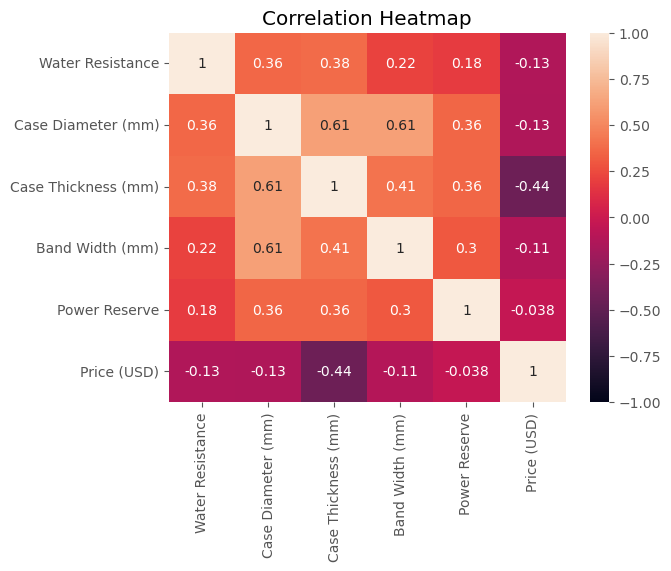

In [36]:
# look at correlation for the numerical features
numerical = ['Water Resistance', 'Case Diameter (mm)',
       'Case Thickness (mm)', 'Band Width (mm)', 'Power Reserve',
       'Price (USD)']
sns.heatmap(watches[numerical].corr(), vmin = -1, vmax = 1, annot = True)
plt.title('Correlation Heatmap')

Looking at the correlations between the numerical features there appears to be a potential multicollinearity issue between Case Diameter (mm), Case Thickness (mm) and Band Width (mm).

In [37]:
watches[numerical].describe()

,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Power Reserve,Price (USD)
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,122.067511,41.161603,11.653565,21.159283,59.274262,12324.641350
std,150.287771,2.229070,2.434456,1.613385,23.219349,10500.833329
min,30.000000,33.000000,5.150000,16.000000,38.000000,495.000000
25%,50.000000,40.000000,9.800000,20.000000,45.000000,5825.000000
50%,100.000000,41.000000,12.140000,20.000000,55.000000,8500.000000
75%,120.000000,42.000000,13.320000,22.000000,70.000000,16950.000000
max,2000.000000,46.500000,16.950000,28.000000,270.000000,70000.000000


/Users/karolina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Distribution of Price')

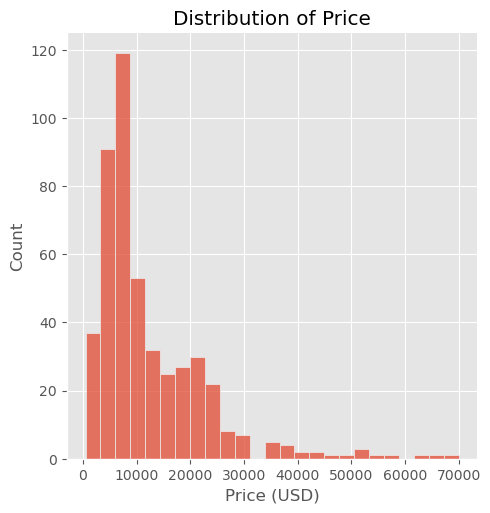

In [38]:
# what's the distribution of the target: Price
sns.displot(watches['Price (USD)'])
plt.title('Distribution of Price')

Text(0.5, 1.0, 'Water Resistance')

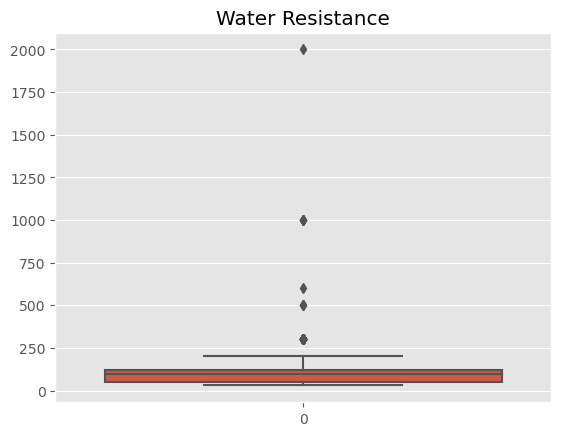

In [39]:
# what's the distribution of Water resistance 
sns.boxplot(watches['Water Resistance'])
plt.title('Water Resistance')

Text(0.5, 1.0, 'Case Diameter (mm)')

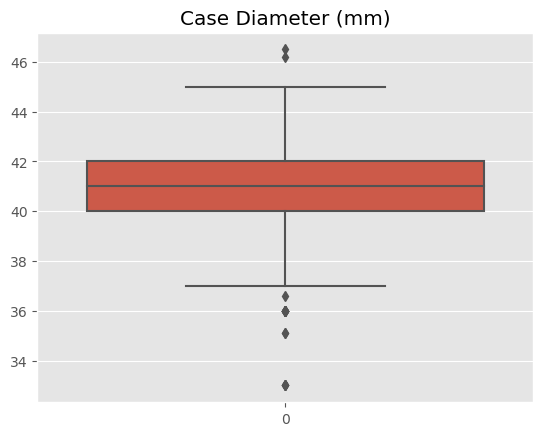

In [40]:
# what's the distribution of Water resistance 
sns.boxplot(watches['Case Diameter (mm)'])
plt.title('Case Diameter (mm)')

Text(0.5, 1.0, 'Case Thickness (mm)')

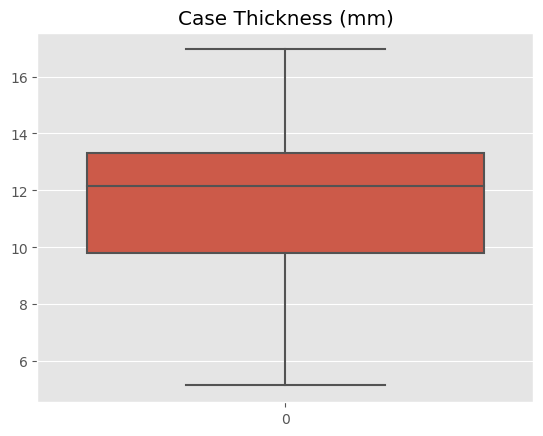

In [41]:
# what's the distribution of Water resistance 
sns.boxplot(watches['Case Thickness (mm)'])
plt.title('Case Thickness (mm)')

Text(0.5, 1.0, 'Band Width (mm)')

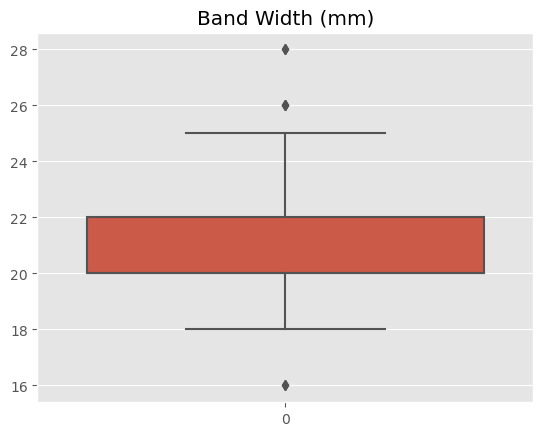

In [42]:
# what's the distribution of Water resistance 
sns.boxplot(watches['Band Width (mm)'])
plt.title('Band Width (mm)')

Text(0.5, 1.0, 'Power Reserve')

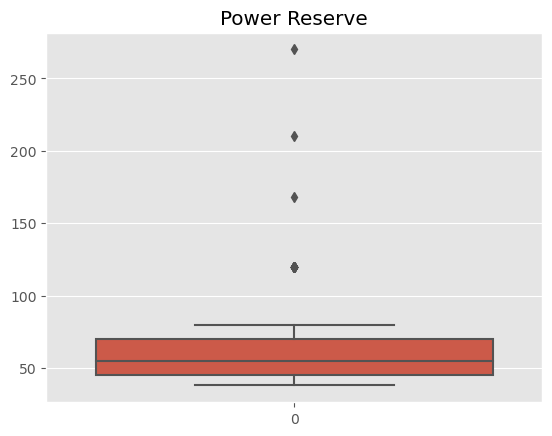

In [43]:
# what's the distribution of Water resistance 
sns.boxplot(watches['Power Reserve'])
plt.title('Power Reserve')

Looking at the boxplots of the numerical features we can see that there is quite a lot of outliers present in all but the case thickness features. Additionally, looking at the distribution of the price column we can see that the data is right skewed. 

# Feature Selection 

In [44]:
# train test split
# split into train and test data
X = watches[[ 'Water Resistance', 'Case Diameter (mm)',
       'Case Thickness (mm)', 'Band Width (mm)', 'Power Reserve',
       'Chronograph_comp', 'Cyclops_comp', 'Cyclops Lens_comp',
       'Date_comp', 'Dual Time Zone_comp', 'Flyback_comp', 'GMT_comp',
       'Moon Phase_comp', 'Moonphase_comp', 'Power Reserve_comp',
       'Power Reserve Indicator_comp', 'Rotating Bezel_comp',
       'Second Time Zone_comp', 'Stopwatch_comp', 'Sub Seconds_comp',
       'Tachymeter_comp', 'Unidirectional Bezel_comp', 'World Time_comp',
       '18k king gold_case', '18k rose gold_case', '18k white gold_case',
       '18k yellow gold_case', 'bronze_case', 'carbon fiber_case',
       'ceramic_case', 'german submarine steel_case', 'rose gold_case',
       'stainless steel_case', 'titanium_case', 'white gold_case',
       'yellow gold_case', 'Alligator_strap', 'Canvas_strap', 'Fabric_strap',
       'Jubilee_strap', 'Jubilee Bracelet_strap', 'Leather_strap',
       'NATO Strap_strap', 'NATO strap_strap', 'Rose Gold_strap',
       'Rubber_strap', 'Silicone_strap', 'Stainless Steel_strap',
       'Textile_strap', 'Titanium_strap', 'Automatic_mov', 'Eco-Drive_mov',
       'Manual_mov', 'Black_dial', 'Blue_dial', 'Champagne_dial', 'Grey_dial',
       'Ivory_dial', 'Silver_dial', 'White_dial', 'Hardlex_crystal',
       'Hesalite_crystal', 'Mineral_crystal', 'Sapphire_crystal']]
y = watches['Price (USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [45]:
X_train.shape

(379, 64)

In [46]:
X_test.shape

(95, 64)

In [47]:
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
# Begin looking at a linear regression model
lmodel = LinearRegression()
fs = SequentialFeatureSelector(lmodel, n_features_to_select='auto', tol=60, direction='forward', scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
fs.fit(X_train,y_train)
fs.n_features_to_select_

10

In [49]:
fs.get_feature_names_out([ 'Water Resistance', 'Case Diameter (mm)',
       'Case Thickness (mm)', 'Band Width (mm)', 'Power Reserve',
        'Chronograph_comp', 'Cyclops_comp', 'Cyclops Lens_comp',
       'Date_comp', 'Dual Time Zone_comp', 'Flyback_comp', 'GMT_comp',
       'Moon Phase_comp', 'Moonphase_comp', 'Power Reserve_comp',
       'Power Reserve Indicator_comp', 'Rotating Bezel_comp',
       'Second Time Zone_comp', 'Stopwatch_comp', 'Sub Seconds_comp',
       'Tachymeter_comp', 'Unidirectional Bezel_comp', 'World Time_comp',
       '18k king gold_case', '18k rose gold_case', '18k white gold_case',
       '18k yellow gold_case', 'bronze_case', 'carbon fiber_case',
       'ceramic_case', 'german submarine steel_case', 'rose gold_case',
       'stainless steel_case', 'titanium_case', 'white gold_case',
       'yellow gold_case', 'Alligator_strap', 'Canvas_strap', 'Fabric_strap',
       'Jubilee_strap', 'Jubilee Bracelet_strap', 'Leather_strap',
       'NATO Strap_strap', 'NATO strap_strap', 'Rose Gold_strap',
       'Rubber_strap', 'Silicone_strap', 'Stainless Steel_strap',
       'Textile_strap', 'Titanium_strap', 'Automatic_mov', 'Eco-Drive_mov',
       'Manual_mov', 'Black_dial', 'Blue_dial', 'Champagne_dial', 'Grey_dial',
       'Ivory_dial', 'Silver_dial', 'White_dial', 'Hardlex_crystal',
       'Hesalite_crystal', 'Mineral_crystal', 'Sapphire_crystal'])

array(['Case Diameter (mm)', 'Case Thickness (mm)', 'Date_comp',
       'Moon Phase_comp', 'stainless steel_case', 'titanium_case',
       'Leather_strap', 'Rubber_strap', 'Silicone_strap', 'Blue_dial'],
      dtype=object)

In [50]:
X_train1 = fs.transform(X_train)
X_test1 = fs.transform(X_test)
lmodel.fit(X_train1,y_train)
print(lmodel.score(X_train1, y_train), mean_squared_error(lmodel.predict(X_train1), y_train, squared = False))

0.5324595843102378 7599.1082586463235


In [51]:
print(lmodel.score(X_test1, y_test), mean_squared_error(lmodel.predict(X_test1), y_test, squared = False))

0.24176581525934648 6268.867405041969


Text(0.5, 1.0, 'Residuals vs. Fitted values plot')

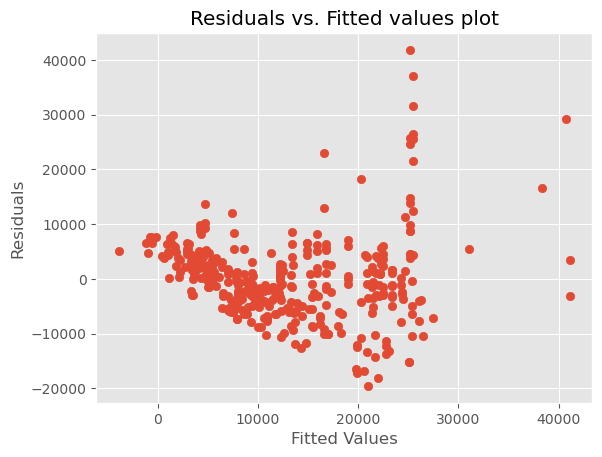

In [52]:
# does it meet the linear regression assumptions
# look at the residuals to evaluate linear regression assumptions
train_pred = lmodel.predict(X_train1) 
res = y_train - train_pred
plt.scatter(train_pred, res)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values plot')

The Residual vs. Fitted model plot shows a cornucupia shape and does not meet the assumptions.

Text(0.5, 1.0, 'QQ Plot of Residuals')

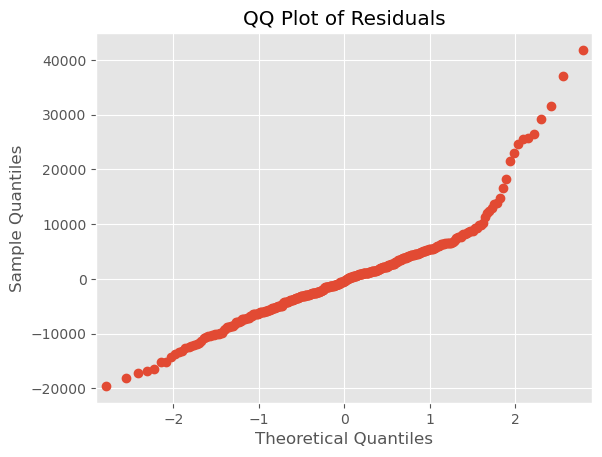

In [53]:
# QQplot
sm.qqplot(res)
plt.title('QQ Plot of Residuals')

The QQplot also shows issues related to the normality assumptions. This together with the residual vs. fitted plot as well as the result of the linear model indicates that for this problem a linear model is not ideal. 

In [54]:
# Does random forest regressor perform better?
rmodel = RandomForestRegressor(random_state = 3)

In [55]:
# initial parameters
rmodel.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

In [56]:
# select best features using forwards selection 
fs = SequentialFeatureSelector(rmodel, n_features_to_select='auto', tol=60, direction='forward', scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
fs.fit(X_train,y_train)
fs.n_features_to_select_

6

In [57]:
# what features
fs.get_feature_names_out([ 'Water Resistance', 'Case Diameter (mm)',
       'Case Thickness (mm)', 'Band Width (mm)', 'Power Reserve',
        'Chronograph_comp', 'Cyclops_comp', 'Cyclops Lens_comp',
       'Date_comp', 'Dual Time Zone_comp', 'Flyback_comp', 'GMT_comp',
       'Moon Phase_comp', 'Moonphase_comp', 'Power Reserve_comp',
       'Power Reserve Indicator_comp', 'Rotating Bezel_comp',
       'Second Time Zone_comp', 'Stopwatch_comp', 'Sub Seconds_comp',
       'Tachymeter_comp', 'Unidirectional Bezel_comp', 'World Time_comp',
       '18k king gold_case', '18k rose gold_case', '18k white gold_case',
       '18k yellow gold_case', 'bronze_case', 'carbon fiber_case',
       'ceramic_case', 'german submarine steel_case', 'rose gold_case',
       'stainless steel_case', 'titanium_case', 'white gold_case',
       'yellow gold_case', 'Alligator_strap', 'Canvas_strap', 'Fabric_strap',
       'Jubilee_strap', 'Jubilee Bracelet_strap', 'Leather_strap',
       'NATO Strap_strap', 'NATO strap_strap', 'Rose Gold_strap',
       'Rubber_strap', 'Silicone_strap', 'Stainless Steel_strap',
       'Textile_strap', 'Titanium_strap', 'Automatic_mov', 'Eco-Drive_mov',
       'Manual_mov', 'Black_dial', 'Blue_dial', 'Champagne_dial', 'Grey_dial',
       'Ivory_dial', 'Silver_dial', 'White_dial', 'Hardlex_crystal',
       'Hesalite_crystal', 'Mineral_crystal', 'Sapphire_crystal'])

array(['Case Thickness (mm)', 'Power Reserve', 'Chronograph_comp',
       'stainless steel_case', 'Rubber_strap', 'Stainless Steel_strap'],
      dtype=object)

In [58]:
X_train2 = fs.transform(X_train)
X_test2 = fs.transform(X_test)
rmodel.fit(X_train2, y_train)
print(rmodel.score(X_train2, y_train), mean_squared_error(rmodel.predict(X_train2), y_train, squared = False))

0.9110345709926655 3314.848549809078


In [59]:
print(rmodel.score(X_test2, y_test), mean_squared_error(rmodel.predict(X_test2), y_test, squared = False))

0.7656959111036945 3484.7958234097955


The random forest regresson model clearly perform better than the linear regression model. This is probably because the random forest regression model is able to learn the non linear relationships in the data that the linear model is unable to capture.

In [60]:
# Fine tuning the random forest regressor using randomized grid search
grid = {
    'n_estimators': [100,500,700,1000],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [None, 5, 10, 50,70,100],
    'min_samples_split': [2, 5,7,10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]    
}

# do the search
gridSearch = RandomizedSearchCV(estimator = rmodel, param_distributions = grid, scoring = 'neg_root_mean_squared_error', cv = 3, random_state = 3, n_jobs = -1)
gridSearch.fit(X_train2, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=3),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 50, 70, 100],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [100, 500, 700, 1000]},
                   random_state=3, scoring='neg_root_mean_squared_error')

In [61]:
BestEstimator = gridSearch.best_estimator_
BestEstimator

RandomForestRegressor(max_depth=10, max_features='log2', random_state=3)

In [62]:
gridSearch.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [63]:
BestEstimator.fit(X_train2,y_train)
print(BestEstimator.score(X_train2, y_train), mean_squared_error(BestEstimator.predict(X_train2), y_train, squared = False))

0.9066412075095327 3395.710560155618


In [64]:
print(BestEstimator.score(X_test2, y_test), mean_squared_error(BestEstimator.predict(X_test2), y_test, squared = False))

0.7787362279436515 3386.4335621995065
